# Tests with Kronos for Forcasting


In [ ]:
%pip install transformers torch einops

In [1]:
import sys
import os
import torch
import pandas as pd 
import matplotlib.pyplot as plt

assert os.getcwd().endswith("ai_scratch"), "Please run this notebook from the ai_scratch directory."

PATH_PREFIX = "notebooks/kronos/"

# Ensure the kronos directory is in the Python path.
sys.path.append(os.getcwd() + f"/{PATH_PREFIX}")

from model import Kronos, KronosTokenizer, KronosPredictor

In [2]:
# Load from Hugging Face Hub
tokenizer = KronosTokenizer.from_pretrained("NeoQuasar/Kronos-Tokenizer-base")
model = Kronos.from_pretrained("NeoQuasar/Kronos-base")

In [3]:
# Instantiate Predictor

if torch.backends.mps.is_available():
    device = "mps"
    print("Using MPS")
elif torch.cuda.is_available():
    device = "cuda:0"
    print("Using CUDA")
else:
    device = "cpu"
    print("Using CPU")

predictor = KronosPredictor(model, tokenizer, device=device, max_context=512)

Using MPS


In [4]:
def plot_prediction(kline_df, pred_df):
    pred_df.index = kline_df.index[-pred_df.shape[0]:]
    sr_close = kline_df['close']
    sr_pred_close = pred_df['close']
    sr_close.name = 'Ground Truth'
    sr_pred_close.name = "Prediction"

    sr_volume = kline_df['volume']
    sr_pred_volume = pred_df['volume']
    sr_volume.name = 'Ground Truth'
    sr_pred_volume.name = "Prediction"

    close_df = pd.concat([sr_close, sr_pred_close], axis=1)
    volume_df = pd.concat([sr_volume, sr_pred_volume], axis=1)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

    ax1.plot(close_df['Ground Truth'], label='Ground Truth', color='blue', linewidth=1.5)
    ax1.plot(close_df['Prediction'], label='Prediction', color='red', linewidth=1.5)
    ax1.set_ylabel('Close Price', fontsize=14)
    ax1.legend(loc='lower left', fontsize=12)
    ax1.grid(True)

    ax2.plot(volume_df['Ground Truth'], label='Ground Truth', color='blue', linewidth=1.5)
    ax2.plot(volume_df['Prediction'], label='Prediction', color='red', linewidth=1.5)
    ax2.set_ylabel('Volume', fontsize=14)
    ax2.legend(loc='upper left', fontsize=12)
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

## Check the dataframe slicing logic

In [5]:
import numpy as np

# Generate a DataFrame with 20 rows and columns 'x' and 'y' with random numeric values
df = pd.DataFrame({
    'x': np.random.rand(20),
    'y': np.random.rand(20)
})

print(f"{df=}")

last_n = 10
# Take the first `lookback` rows for x and the next `pred_len` rows for y.
lookback = 5
pred_len = 5

assert lookback <= df.shape[0], "Lookback exceeds DataFrame length."

# Only keep the last `last_n` rows.
df = df.tail(last_n)

x_df = df.iloc[:lookback][['x']]
x_timestamp = df.iloc[:lookback]['x']
y_timestamp = df.iloc[lookback:lookback+pred_len]['y']

print(f"{x_df=}")
print("\n---\n")

print(f"{x_timestamp=}")
print("\n---\n")

print(f"{y_timestamp=}")

def print_diagnostics():
    print(f"{type(x_df)}=")
    print(f"{type(x_timestamp)}")
    print(f"{type(y_timestamp)}")

print_diagnostics()

df=           x         y
0   0.754792  0.492936
1   0.567791  0.026559
2   0.029251  0.576285
3   0.622685  0.419839
4   0.519901  0.591891
5   0.664243  0.593603
6   0.729080  0.359735
7   0.163413  0.395047
8   0.270547  0.780716
9   0.433369  0.512746
10  0.232704  0.058390
11  0.265773  0.342374
12  0.383094  0.454298
13  0.152482  0.925808
14  0.551926  0.581409
15  0.981024  0.917821
16  0.288778  0.554413
17  0.491309  0.749314
18  0.281094  0.736852
19  0.169915  0.139292
x_df=           x
10  0.232704
11  0.265773
12  0.383094
13  0.152482
14  0.551926

---

x_timestamp=10    0.232704
11    0.265773
12    0.383094
13    0.152482
14    0.551926
Name: x, dtype: float64

---

y_timestamp=15    0.917821
16    0.554413
17    0.749314
18    0.736852
19    0.139292
Name: y, dtype: float64
<class 'pandas.core.frame.DataFrame'>=
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


## Try with sample data

In [33]:
def load_sample_data():
    df = pd.read_csv("notebooks/kronos/examples/data/XSHG_5min_600977.csv")
    df['timestamps'] = pd.to_datetime(df['timestamps'])
    return df

df = load_sample_data()

last_n = 600
lookback = 400
pred_len = 5

assert lookback <= df.shape[0], "Lookback exceeds DataFrame length."

df = df.tail(last_n)

x_df = df.iloc[:lookback][['open', 'high', 'low', 'close', 'volume', 'amount']]
x_timestamp = df.iloc[:lookback]['timestamps']
y_timestamp = df.iloc[lookback:lookback+pred_len]['timestamps']

print_diagnostics()

<class 'pandas.core.frame.DataFrame'>=
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


In [7]:
x_df

,open,high,low,close,volume,amount
1900,10.58,10.67,10.54,10.54,2531.0,2677092.0
1901,10.54,10.55,10.51,10.51,2335.0,2458889.0
1902,10.52,10.55,10.49,10.54,3952.0,4152949.0
1903,10.55,10.56,10.48,10.48,1717.0,1804275.0
1904,10.49,10.51,10.47,10.48,1913.0,2006734.0
...,...,...,...,...,...,...
2295,9.81,9.81,9.80,9.80,419.0,410959.0
2296,9.80,9.82,9.79,9.80,1118.0,1095862.0
2297,9.81,9.84,9.81,9.82,476.0,467581.0
2298,9.82,9.83,9.81,9.81,382.0,375004.0


In [34]:
x_timestamp

1900   2024-08-13 09:35:00
1901   2024-08-13 09:40:00
1902   2024-08-13 09:45:00
1903   2024-08-13 09:50:00
1904   2024-08-13 09:55:00
               ...        
2295   2024-08-23 10:30:00
2296   2024-08-23 10:35:00
2297   2024-08-23 10:40:00
2298   2024-08-23 10:45:00
2299   2024-08-23 10:50:00
Name: timestamps, Length: 400, dtype: datetime64[ns]

In [35]:
y_timestamp

2300   2024-08-23 10:55:00
2301   2024-08-23 11:00:00
2302   2024-08-23 11:05:00
2303   2024-08-23 11:10:00
2304   2024-08-23 11:15:00
Name: timestamps, dtype: datetime64[ns]

In [36]:
# 4. Make Prediction
pred_df = predictor.predict(
    df=x_df,
    x_timestamp=x_timestamp,
    y_timestamp=y_timestamp,
    pred_len=pred_len,
    T=1.0,
    top_p=0.9,
    sample_count=1,
    verbose=True
)

# 5. Visualize Results
print("Forecasted Data Head:")
print(pred_df.head())


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.97it/s]


Forecasted Data Head:
                         open      high       low     close      volume  \
timestamps                                                                
2024-08-23 10:55:00  9.852448  9.848932  9.839321  9.838639  499.347961   
2024-08-23 11:00:00  9.846340  9.844901  9.834969  9.835340  518.891724   
2024-08-23 11:05:00  9.837322  9.843649  9.835585  9.842671  239.695801   
2024-08-23 11:10:00  9.841805  9.846587  9.839914  9.845357  197.445557   
2024-08-23 11:15:00  9.851544  9.848897  9.838502  9.838508  451.969910   

                         amount  
timestamps                       
2024-08-23 10:55:00  513723.125  
2024-08-23 11:00:00  529611.625  
2024-08-23 11:05:00  247871.000  
2024-08-23 11:10:00  206644.625  
2024-08-23 11:15:00  461648.750  


Visually compare the predicted close prices

In [37]:
def get_pred_vs_actual(pred_df, actual_df, colname):
   actual =  actual_df[colname].reset_index(drop=True)
   pred = pred_df[colname].reset_index(drop=True)
   pred_vs_actual_df = pd.DataFrame({
        'actual': actual,
        'pred': pred,
        'diff_pred_vs_actual': pred - actual
    })
   
   return(pred_vs_actual_df)

get_pred_vs_actual(pred_df, df.iloc[lookback:lookback+pred_len], 'close')

,actual,pred,diff_pred_vs_actual
0,9.81,9.838639,0.028639
1,9.80,9.835340,0.035340
2,9.81,9.842671,0.032671
3,9.83,9.845357,0.015357
4,9.85,9.838508,-0.011492


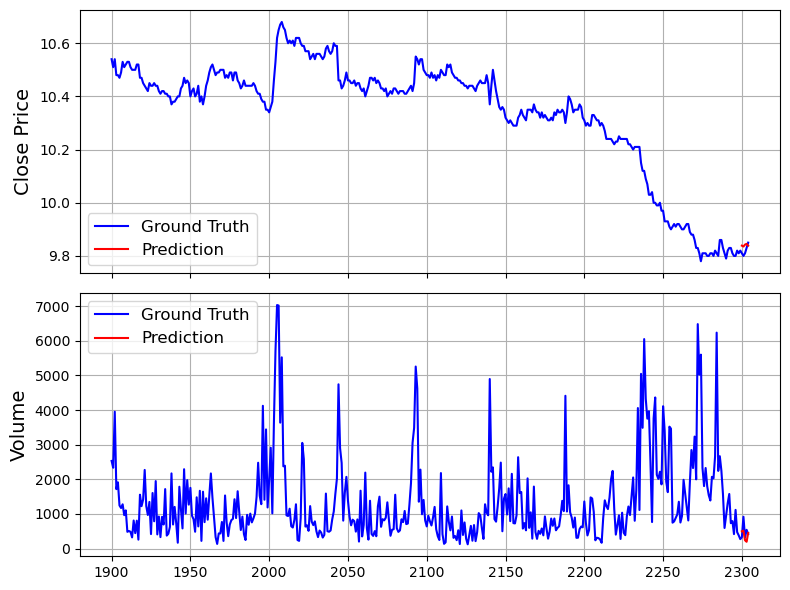

In [ ]:
# Combine historical and forecasted data for plotting
kline_df = df.iloc[:lookback+pred_len]

# Visualize
plot_prediction(kline_df, pred_df)

## Now with BTC real data

In [56]:
def load_btc_data():
    df = pd.read_csv(f"{PATH_PREFIX}/data/bitcoin_historical_data.csv")
    df['timestamps'] = pd.to_datetime(df['timestamps'])
    
    return df
df = load_btc_data()

df

,timestamps,open,high,low,close,volume,amount
0,2025-09-30 23:00:00,113940.40,114048.94,113765.42,114048.93,268.43760,3.057513e+07
1,2025-10-01 00:00:00,114048.94,114308.00,113966.67,114239.53,434.59016,4.959424e+07
2,2025-10-01 01:00:00,114239.53,114550.00,114142.99,114549.99,597.25360,6.830362e+07
3,2025-10-01 02:00:00,114549.99,114551.76,114272.15,114272.15,508.42422,5.816229e+07
4,2025-10-01 03:00:00,114272.16,114530.48,114096.58,114176.92,502.30318,5.743945e+07
...,...,...,...,...,...,...,...
424,2025-10-18 15:00:00,107028.37,107146.18,106815.86,106948.75,336.98269,3.605727e+07
425,2025-10-18 16:00:00,106948.75,107063.89,106484.00,106664.01,353.04791,3.767868e+07
426,2025-10-18 17:00:00,106664.01,106955.79,106567.95,106880.03,246.03342,2.626449e+07
427,2025-10-18 18:00:00,106880.04,106920.00,106722.72,106843.75,158.99856,1.698354e+07


In [ ]:
last_n = 200
lookback = 10
pred_len = 10

assert lookback <= df.shape[0], "Lookback exceeds DataFrame length."

df = df.tail(last_n)

x_df = df.iloc[:lookback][['open', 'high', 'low', 'close', 'volume', 'amount']]
x_timestamp = df.iloc[:lookback]['timestamps']
y_timestamp = df.iloc[lookback:lookback+pred_len]['timestamps']

In [58]:
x_df

,open,high,low,close,volume,amount
409,106431.68,106845.52,106322.20,106845.52,471.69377,5.029392e+07
410,106845.52,107306.06,106824.00,107149.30,525.12520,5.621495e+07
411,107149.30,107297.87,106493.23,106597.98,923.59727,9.868328e+07
412,106597.97,107126.55,106573.60,107070.40,747.88716,7.995108e+07
413,107070.41,107070.41,106439.38,106478.71,738.59104,7.877292e+07
414,106478.66,106842.50,106478.66,106812.52,357.02039,3.808832e+07
415,106812.52,106950.00,106711.95,106839.96,582.06053,6.220248e+07
416,106839.97,107499.00,106607.20,106665.00,1298.66311,1.390867e+08
417,106665.01,106966.62,106605.93,106719.20,1204.63747,1.286366e+08
418,106719.20,106938.00,106629.66,106884.41,371.44202,3.965901e+07


In [59]:
x_timestamp

409   2025-10-18 00:00:00
410   2025-10-18 01:00:00
411   2025-10-18 02:00:00
412   2025-10-18 03:00:00
413   2025-10-18 04:00:00
414   2025-10-18 05:00:00
415   2025-10-18 06:00:00
416   2025-10-18 07:00:00
417   2025-10-18 08:00:00
418   2025-10-18 09:00:00
Name: timestamps, dtype: datetime64[ns]

In [60]:
y_timestamp

419   2025-10-18 10:00:00
420   2025-10-18 11:00:00
421   2025-10-18 12:00:00
422   2025-10-18 13:00:00
423   2025-10-18 14:00:00
424   2025-10-18 15:00:00
425   2025-10-18 16:00:00
426   2025-10-18 17:00:00
427   2025-10-18 18:00:00
428   2025-10-18 19:00:00
Name: timestamps, dtype: datetime64[ns]

In [41]:
print_diagnostics()

<class 'pandas.core.frame.DataFrame'>=
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


In [61]:
# 4. Make Prediction
pred_df = predictor.predict(
    df=x_df,
    x_timestamp=x_timestamp,
    y_timestamp=y_timestamp,
    pred_len=pred_len,
    T=1.0,
    top_p=0.9,
    sample_count=1,
    verbose=True
)

# 5. Visualize Results
print("Forecasted Data Head:")
print(pred_df.head())

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.49it/s]


Forecasted Data Head:
                              open           high            low  \
timestamps                                                         
2025-10-18 10:00:00  106625.476562  106872.750000  106519.062500   
2025-10-18 11:00:00  106853.289062  107101.179688  106589.093750   
2025-10-18 12:00:00  106842.843750  107105.226562  106508.875000   
2025-10-18 13:00:00  106624.304688  106857.859375  106323.867188   
2025-10-18 14:00:00  106381.726562  106983.718750  106498.359375   

                             close      volume      amount  
timestamps                                                  
2025-10-18 10:00:00  106679.617188  824.155518  84487664.0  
2025-10-18 11:00:00  106742.585938  800.050964  85102568.0  
2025-10-18 12:00:00  106566.351562  929.883240  97856832.0  
2025-10-18 13:00:00  106499.148438  855.285034  87270312.0  
2025-10-18 14:00:00  106814.578125  447.281982  47411752.0  


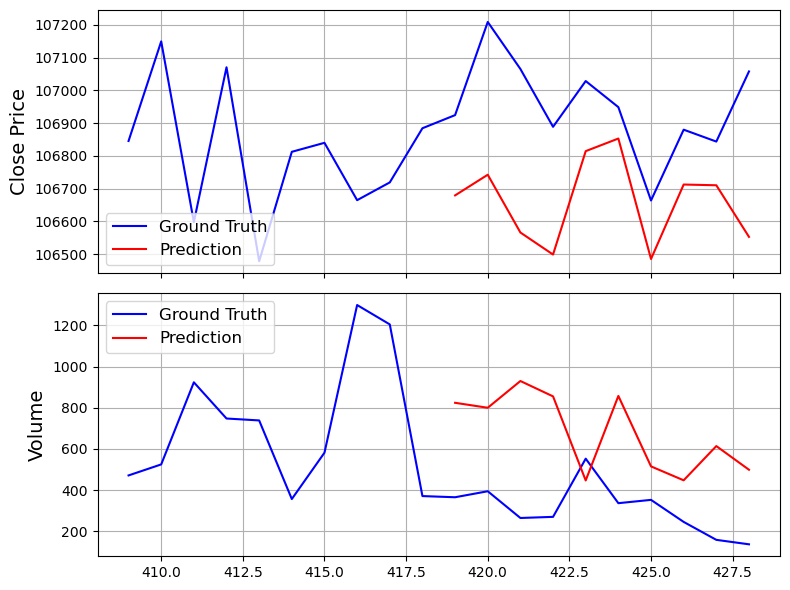

In [62]:
# Combine historical and forecasted data for plotting
kline_df = df.iloc[:lookback+pred_len]

# Visualize
plot_prediction(kline_df, pred_df)